# Full images to patches

In [1]:
import torch
import random
from datetime import datetime
import PIL

from tqdm import tqdm_notebook as tqdm

In [2]:
import torchvision.transforms as T
import torchvision.transforms.functional as TF

In [3]:
from dataset import *
from show import *
from utils import *
from constants import *
from augmentation import *

In [4]:
def create_path(name, idx, ext):
    return '/data/images/original/{}_{:03d}.{}'.format(name, idx, ext)

In [5]:
img_dir = '{}/labels'.format(path_to_data)
img_paths = [os.path.join(img_dir, fname) for fname in sorted(os.listdir(img_dir))]

In [6]:
def get_img_lbl(i, from_torch=False):
    if from_torch:
        return tuple_to_pil(torch.load(create_path('img', i, 'torch')), torch.load(create_path('lbl', i, 'torch')))
    else:
        return load_png_tuple('{}/images/original'.format(path_to_data), i)

def get_patches(i, ncrops_multiplier=1, as_tensor=True):
    return aug_pipeline(*get_img_lbl(i), ncrops_multiplier=ncrops_multiplier, as_tensor=as_tensor)

In [7]:
images_labels = list(get_img_lbl(i) for i in range(num_images))

In [8]:
img, lbl = get_img_lbl(28)
img, lbl = T.ToTensor()(img), (T.ToTensor()(lbl)*255).int()

(2048, 3072, 3) (2048, 3072, 1)


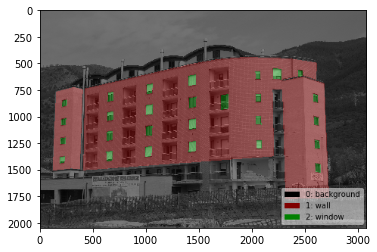

In [9]:
show_labeled_img(img, lbl)

## full-res image to 2 rotations
One with angle [-10, -5] and one with [5, 10]

Cropped such that it does not include black borders

In [10]:
img_2_rot = gen_2_rot(img, lbl)

In [11]:
i0, l0 = img_2_rot[1][0], img_2_rot[1][1]

(1709, 2885, 3) (1709, 2885, 1)


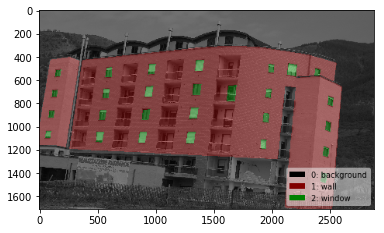

In [12]:
show_labeled_img(i0, l0, label_name_to_value)

## full-res image without useless borders

In [13]:
i1, l1 = cut_borders(i0, l0)

(1499, 2715, 3) (1499, 2715, 1)


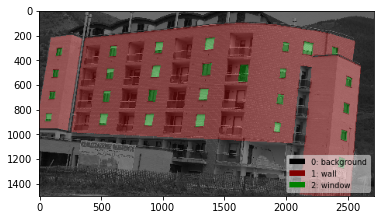

In [14]:
show_labeled_img(i1, l1, label_name_to_value)

## full-res image to crops

In [15]:
w,h = l1.shape[1:]
crop_size = min(w, h) // 3
ncrops = round(0.5 * w/crop_size * h/crop_size)
ncrops

8

In [16]:
crops = gen_crops(i1, l1, crop_size, ncrops)
len(crops)

8

(256, 256, 3) (256, 256, 1)


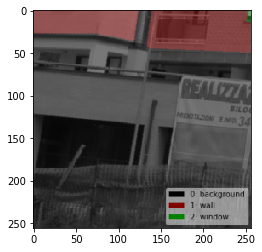

In [17]:
show_labeled_img(*crops[0], label_name_to_value)

## crops tranformations

### horizontal flips

(256, 256, 3) (256, 256, 1)


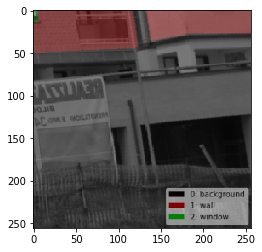

In [18]:
show_labeled_img(*random_flip(*crops[0], p=1), label_name_to_value)

### brightness + contrast

torch.Size([1713, 5776, 3])


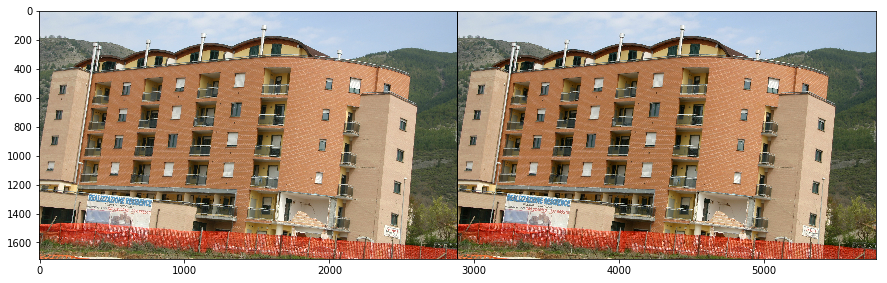

In [19]:
plt.figure(figsize=(15,8))
show_img(make_grid([i0, random_brightness_and_contrast(i0, l0)[0]]))

## Whole pipeline

In [20]:
img = Image.open('/data/images/original/img_000.png')
lbl = Image.open('/data/images/original/lbl_000.png')

In [21]:
img_patches, lbl_patches = aug_pipeline(T.ToTensor()(img), T.ToTensor()(lbl))

torch.Size([776, 1550, 3])


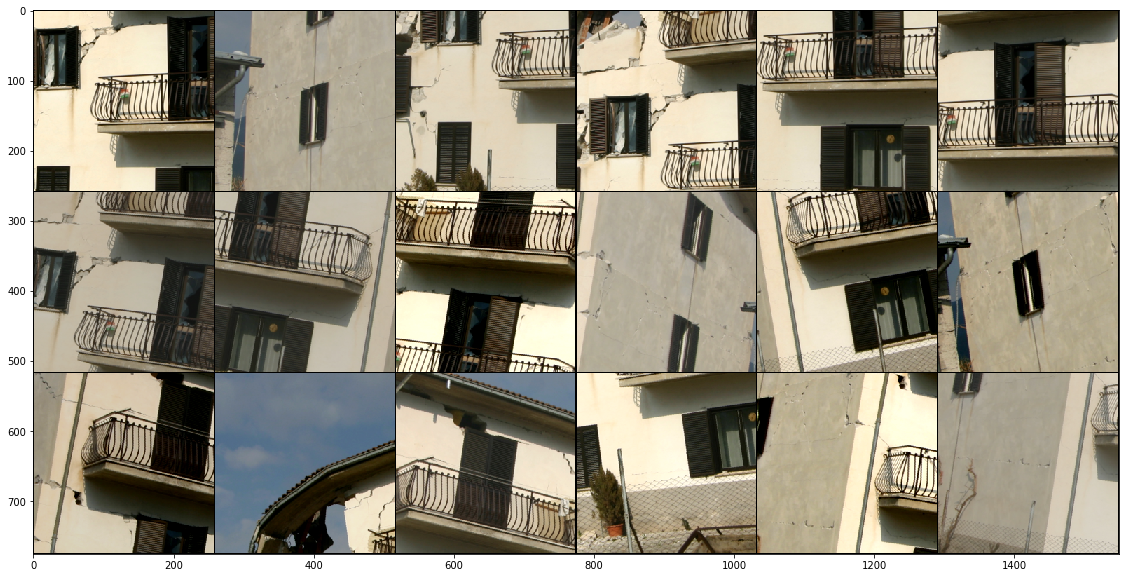

In [22]:
plt.figure(figsize=(20, 10))
show_img(make_grid(img_patches, nrow=6))

torch.Size([776, 1550, 1])


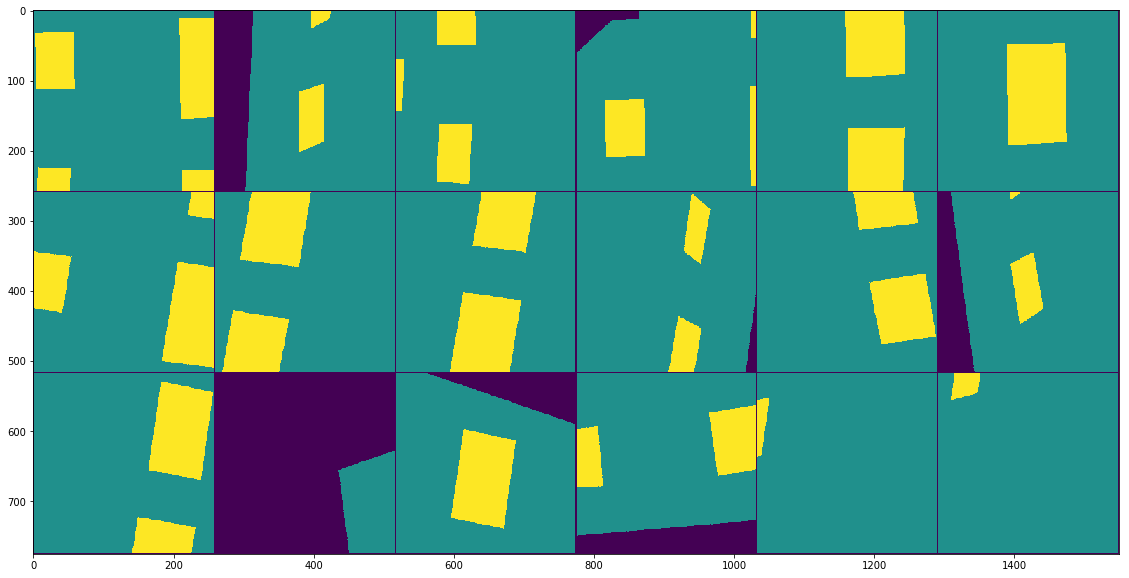

In [23]:
plt.figure(figsize=(20, 10))
show_img(make_grid(lbl_patches, nrow=6)[0:1, :, :])

# Generate rotations with cropped borders

# in case we want to add more rotations
rotation_offset = 0
num_rot = 5

for idx, path in enumerate(tqdm(img_paths)):
    img_original, lbl_original = path_to_tuple(path, label_name_to_value)
    img_pil, lbl_pil = tuple_to_pil(img_original, lbl_original)
    
    for jdx in range(num_rot):
        #saving the original as jdx = 0
        if jdx + rotation_offset > 0:
            angle = random.randint(-10, 10)
            img, lbl = random_rot(img_pil, angle, is_label=False), random_rot(lbl_pil, angle, is_label=True)
            # cut borders
            img, lbl = cut_borders(img, lbl)
        else:
            img, lbl = cut_borders(img_pil, lbl_pil)
            
        # resize
        w,h = img_pil.size
        factor = max_size / max(w,h)
        factor = min(1, factor)
        if factor < 1:
            def resizer(is_label):
                itp = 0 if is_label else 2 #0 is nearest, 2 is bilinear interpolation
                return T.Resize((round(h*factor),round(w*factor)), interpolation=itp)
            img = resizer(is_label=False)(img)
            lbl = resizer(is_label=True)(lbl)

        #img_rot, lbl_rot = random_flip(img_rot, lbl_rot)
        #img_rot, lbl_rot = random_brightness(img_rot, lbl_rot)
        img = T.ToTensor()(img)
        lbl = (T.ToTensor()(lbl) * 255).int()
        
        dir_name = '/data/images/rot_aug_{}'.format(max_size)
        torch.save(img, '{}/img_{:03d}_{:03d}.torch'.format(dir_name, idx, jdx + rotation_offset))
        torch.save(lbl, '{}/lbl_{:03d}_{:03d}.torch'.format(dir_name, idx, jdx + rotation_offset))


In [25]:
def load_sample(img_idx, rot_idx):
    def load(s):
        return torch.load('{}/images/rot_aug_{}/{}_{:03d}_{:03d}.torch'.format(path_to_data, max_size, s, img_idx, rot_idx))
    return load('img'), load('lbl')

In [144]:
%timeit load_sample(0,0)

3.17 ms ± 575 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [145]:
%timeit load_sample(random.randint(0, num_images-1),random.randint(0, num_rotations-1))

3.61 ms ± 53.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


torch.Size([772, 5132, 3])


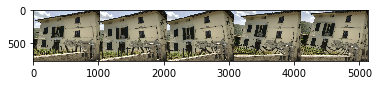

In [149]:
show_img(make_grid([load_sample(200,i)[0] for i in range(5)]))

In [114]:
def random_crop(img, lbl, crop_size=patch_size):
    assert type(img) is torch.Tensor
    
    h,w = img.shape[1:]
    top = random.randint(0, h-patch_size-1)
    left = random.randint(0, w-patch_size-1)
    return img[:, top:top+patch_size, left:left+patch_size],\
            lbl[:, top:top+patch_size, left:left+patch_size]

In [115]:
%timeit random_crop(*load_sample(random.randint(0, num_images-1),random.randint(0, num_rotations-1)))

4.28 ms ± 257 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


torch.Size([256, 256, 3])


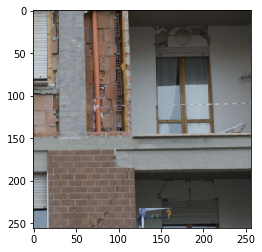

In [116]:
show_img(random_crop(*load_sample(random.randint(0, num_images-1),random.randint(0, num_rotations-1)))[0])

(256, 256, 3) (256, 256, 1)


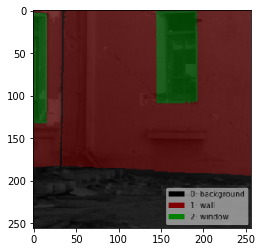

In [117]:
show_labeled_img(*random_crop(*load_sample(random.randint(0, num_images-1),random.randint(0, num_rotations-1))))